# notebooks/02_Feature_Engineering_and_Advanced_EDA.ipynb

In [4]:
%pip install scipy

   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
    --------------------------------------- 0.5/38.6 MB 2.8 MB/s eta 0:00:14
   - -------------------------------------- 1.0/38.6 MB 2.5 MB/s eta 0:00:15
   - -------------------------------------- 1.0/38.6 MB 2.5 MB/s eta 0:00:15
   - -------------------------------------- 1.3/38.6 MB 1.9 MB/s eta 0:00:20
   -- ------------------------------------- 2.4/38.6 MB 2.2 MB/s eta 0:00:17
   --- ------------------------------------ 3.7/38.6 MB 2.9 MB/s eta 0:00:12
   ---- ----------------------------------- 4.2/38.6 MB 3.0 MB/s eta 0:00:12
   ----- ---------------------------------- 5.0/38.6 MB 3.0 MB/s eta 0:00:12
   ----- ---------------------------------- 5.2/38.6 MB 3.0 MB/s eta 0:00:12
   ----- ---------------------------------- 5.8/38.6 MB 2.7 MB/s eta 0:00:13
   ----- ---------------------------------- 5.8/38.6 MB 2.7 MB/s eta 0:00:13
   ------ --------------------------------- 6.0/38.6 MB 2.5 MB/s eta 0:00:13
   ---

Loading and cleaning E-commerce Fraud Data for Feature Engineering...
✅ 'Fraud_Data.csv' loaded successfully from 'd:\EsH\KAIM\week89\fraud-detection-ml\data\raw\Fraud_Data.csv'
✅ 'IpAddress_to_Country.csv' loaded successfully from 'd:\EsH\KAIM\week89\fraud-detection-ml\data\raw\IpAddress_to_Country.csv'
IP address ranges converted to integer format and sorted for efficient lookup.
IP to country mapping complete.
Engineering time-based features for e-commerce data...
Engineering transaction frequency and value-based features...
Feature engineering for e-commerce data complete.

E-commerce Fraud Data with Engineered Features Head:
   user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11            34.0   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54            16.0   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45            15.0   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50            44.0   
4   221365 2

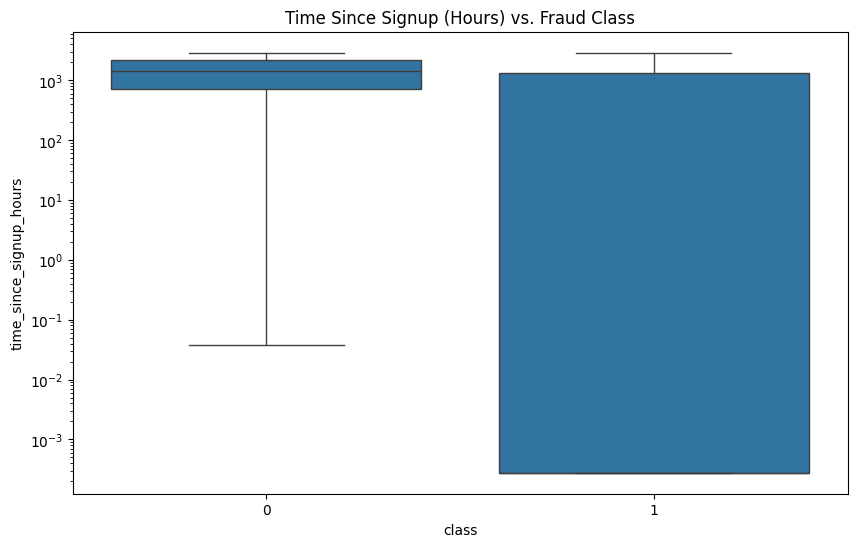

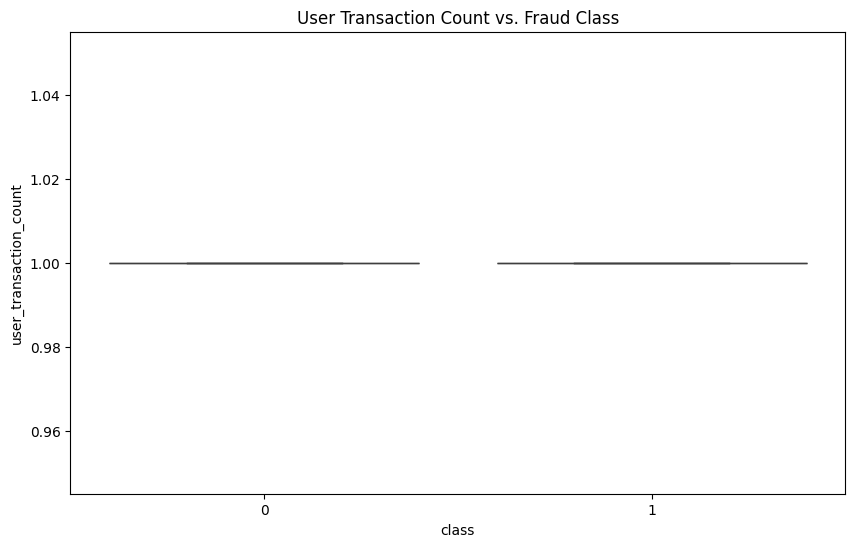

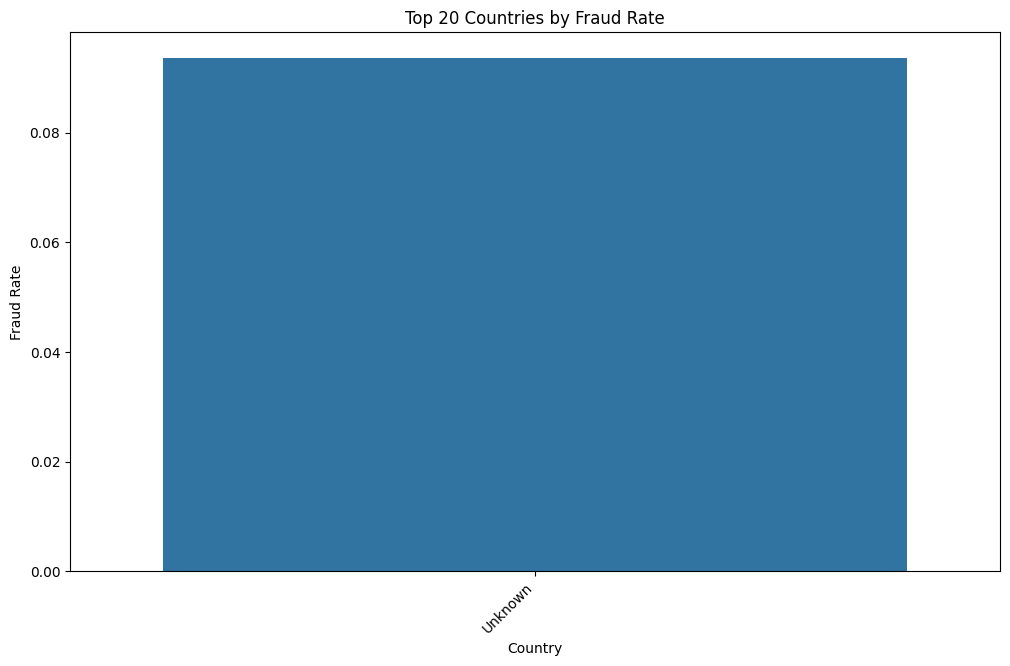

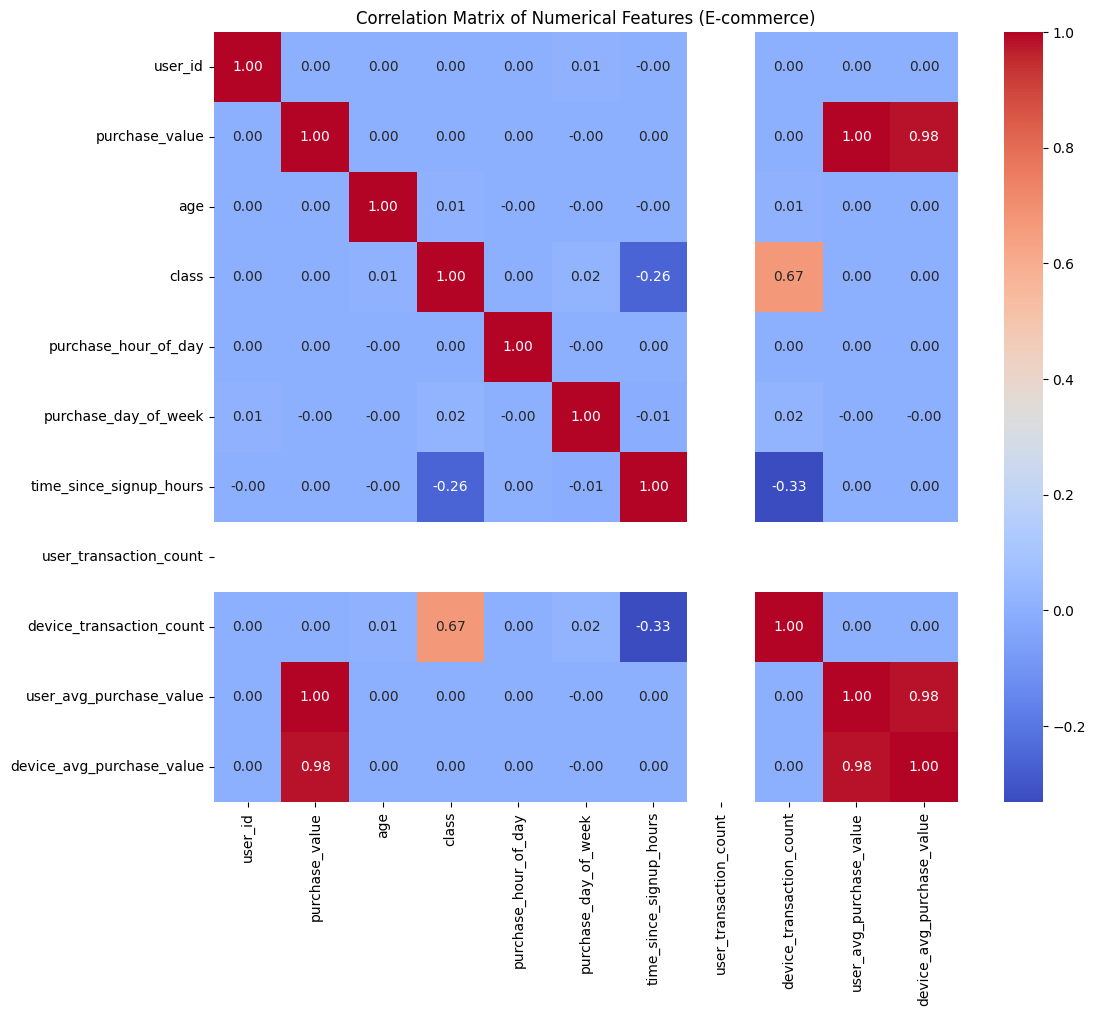

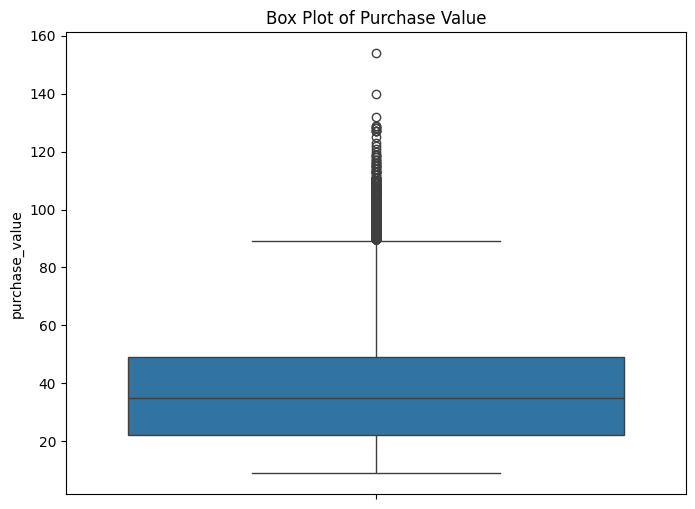


Kruskal-Wallis H-test for Purchase Value between Fraud and Non-Fraud: statistic=0.13, p-value=0.7180
No significant difference in purchase value distributions between fraud and non-fraud.

Loading and cleaning Bank Transaction Fraud Data for Feature Engineering...
✅ 'creditcard.csv' loaded successfully from 'd:\EsH\KAIM\week89\fraud-detection-ml\data\raw\creditcard.csv'
Removed 1081 duplicate rows.
Engineering features for bank transaction data (minimal due to PCA)...
Feature engineering for bank transaction data complete.

Bank Transaction Data with Engineered Features Head:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0     0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1     0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2     1 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3     1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4     2 -1.

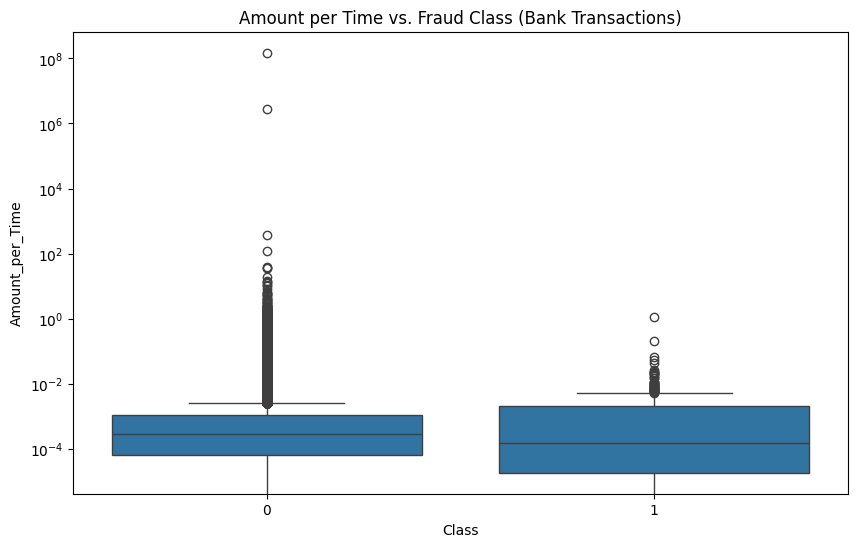

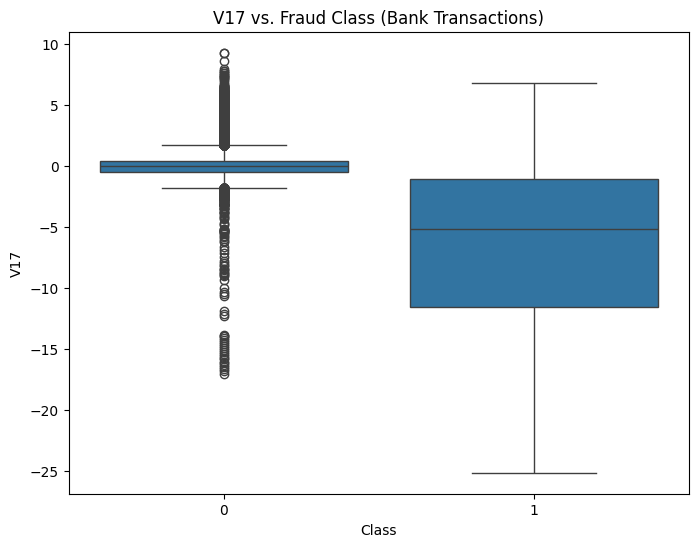


Feature Engineering and Advanced EDA complete. Proceed to Model Experimentation.


In [5]:


import pandas as pd
import numpy as np
from scipy.stats import kruskal
import matplotlib.pyplot as plt
import seaborn as sns
 # Example for non-parametric test
import sys
import os

# Add parent directory to path to import modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from scripts.data_ingestion import DataIngestion
from scripts.data_cleaning import DataCleaner
from scripts.ip_to_country import IPtoCountryMapper
from scripts.feature_engineering import FeatureEngineer

# --- Initialize Utilities ---
ingestor = DataIngestion()
cleaner = DataCleaner()
feature_engineer = FeatureEngineer()

# --- 1. Load and Clean E-commerce Fraud Data (recap from previous notebook/script) ---
print("Loading and cleaning E-commerce Fraud Data for Feature Engineering...")
fraud_df_raw = ingestor.load_fraud_data()
ip_to_country_df_raw = ingestor.load_ip_to_country_data()

if fraud_df_raw is not None and ip_to_country_df_raw is not None:
    # Perform cleaning steps as in handle_class_imbalance.__main__
    fraud_df_cleaned = cleaner.handle_missing_values(fraud_df_raw.copy(), strategy='mean', columns=['age', 'purchase_value'])
    fraud_df_cleaned = cleaner.handle_missing_values(fraud_df_cleaned, strategy='mode', columns=['source', 'browser', 'sex'])
    fraud_df_cleaned = cleaner.remove_duplicates(fraud_df_cleaned)
    type_mapping_fraud = {
        'signup_time': 'datetime64[ns]',
        'purchase_time': 'datetime64[ns]',
        'purchase_value': 'float64',
        'age': 'int64',
        'class': 'int64'
    }
    fraud_df_cleaned = cleaner.correct_data_types(fraud_df_cleaned, type_mapping_fraud)

    # Map IP to country
    fraud_df_cleaned['ip_address'] = fraud_df_cleaned['ip_address'].astype(str).replace('nan', np.nan)
    fraud_df_cleaned = cleaner.handle_missing_values(fraud_df_cleaned, strategy='drop', columns=['ip_address']) # Drop if IP is missing

    mapper = IPtoCountryMapper(ip_to_country_df_raw.copy())
    fraud_df_mapped = mapper.map_ips_to_countries(fraud_df_cleaned)

    # --- 2. Engineer E-commerce Features ---
    fraud_df_engineered = feature_engineer.engineer_ecommerce_features(fraud_df_mapped.copy())
    print("\nE-commerce Fraud Data with Engineered Features Head:")
    print(fraud_df_engineered.head())

    # --- 3. Advanced EDA on Engineered Features (E-commerce) ---
    print("\n--- Advanced EDA for E-commerce Fraud Data ---")

    # Time since signup vs. Fraud
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='class', y='time_since_signup_hours', data=fraud_df_engineered)
    plt.title('Time Since Signup (Hours) vs. Fraud Class')
    plt.yscale('log') # Often skewed, log scale helps
    plt.show()

    # User transaction count vs. Fraud
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='class', y='user_transaction_count', data=fraud_df_engineered)
    plt.title('User Transaction Count vs. Fraud Class')
    plt.show()

    # Country vs. Fraud Rate (Top N countries)
    country_fraud_rate = fraud_df_engineered.groupby('country')['class'].mean().sort_values(ascending=False)
    plt.figure(figsize=(12, 7))
    sns.barplot(x=country_fraud_rate.head(20).index, y=country_fraud_rate.head(20).values)
    plt.title('Top 20 Countries by Fraud Rate')
    plt.ylabel('Fraud Rate')
    plt.xlabel('Country')
    plt.xticks(rotation=45, ha='right')
    plt.show()

    # Correlation Matrix of numerical features
    numerical_cols = fraud_df_engineered.select_dtypes(include=np.number).columns.tolist()
    plt.figure(figsize=(12, 10))
    sns.heatmap(fraud_df_engineered[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Numerical Features (E-commerce)')
    plt.show()

    # Outlier detection example for 'purchase_value'
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=fraud_df_engineered['purchase_value'])
    plt.title('Box Plot of Purchase Value')
    plt.show()

    # Example: Mann-Whitney U test (non-parametric t-test alternative for non-normal data)
    # to see if 'purchase_value' differs significantly between fraud and non-fraud
    fraud_values = fraud_df_engineered[fraud_df_engineered['class'] == 1]['purchase_value'].dropna()
    non_fraud_values = fraud_df_engineered[fraud_df_engineered['class'] == 0]['purchase_value'].dropna()
    if len(fraud_values) > 1 and len(non_fraud_values) > 1:
        stat, p = kruskal(fraud_values, non_fraud_values)
        print(f"\nKruskal-Wallis H-test for Purchase Value between Fraud and Non-Fraud: statistic={stat:.2f}, p-value={p:.4f}")
        if p < 0.05:
            print("Significant difference in purchase value distributions between fraud and non-fraud.")
        else:
            print("No significant difference in purchase value distributions between fraud and non-fraud.")
    else:
        print("Not enough samples in both classes to perform Kruskal-Wallis test for Purchase Value.")


# --- 4. Load and Clean Bank Transaction Fraud Data ---
print("\nLoading and cleaning Bank Transaction Fraud Data for Feature Engineering...")
creditcard_df_raw = ingestor.load_creditcard_data()

if creditcard_df_raw is not None:
    creditcard_df_cleaned = cleaner.remove_duplicates(creditcard_df_raw.copy())
    type_mapping_creditcard = {
        'Time': 'int64',
        'Amount': 'float64',
        'Class': 'int64'
    }
    creditcard_df_cleaned = cleaner.correct_data_types(creditcard_df_cleaned, type_mapping_creditcard)

    # --- 5. Engineer Bank Features ---
    creditcard_df_engineered = feature_engineer.engineer_bank_features(creditcard_df_cleaned.copy())
    print("\nBank Transaction Data with Engineered Features Head:")
    print(creditcard_df_engineered.head())

    # --- 6. Advanced EDA on Engineered Features (Bank Transactions) ---
    print("\n--- Advanced EDA for Bank Transaction Fraud Data ---")

    # Amount_per_Time vs. Fraud
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Class', y='Amount_per_Time', data=creditcard_df_engineered)
    plt.title('Amount per Time vs. Fraud Class (Bank Transactions)')
    plt.yscale('log')
    plt.show()

    # V-features correlation with Class (example for one V-feature)
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Class', y='V17', data=creditcard_df_engineered)
    plt.title('V17 vs. Fraud Class (Bank Transactions)')
    plt.show()


print("\nFeature Engineering and Advanced EDA complete. Proceed to Model Experimentation.")